In [6]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem, Draw, MACCSkeys, rdFMCS, PandasTools
import matplotlib.pyplot as plt

In [7]:
from lib import preprocess_Chembl_data
from lib import OpenSMILES_grammar

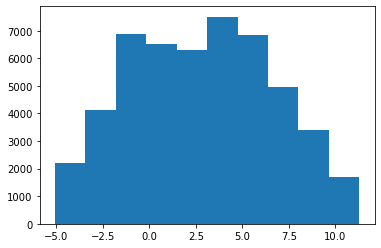

In [8]:
data = pd.read_csv('data/lipo_balanced_training_unique.csv')
plt.hist(data['GenExp'])

gen_exp_list = []
for index in data.index:
    gen_exp_list.append(np.asarray([[data['GenExp'][index]]]))
data['GenExp'] = gen_exp_list

In [9]:
translate = preprocess_Chembl_data.translate
smiles2dummies = preprocess_Chembl_data.smiles2dummies
dummies2smiles = preprocess_Chembl_data.dummies2smiles
charset = sorted(preprocess_Chembl_data.chembl_charset + ['L', 'X', 'Y', 'e', 'K', 'U', 'G'])
max_seq_length = preprocess_Chembl_data.chembl_max_seq_length
num_tokens = len(charset)
num_decoder_tokens = OpenSMILES_grammar.D
token_index = dict(
    [(char, i) for i, char in enumerate(charset)])

L1000_input_smiles = data.input_smiles.values
encoder_input_tokens = np.array([np.array([token_index[char] for char in mol], dtype=int) 
                               for mol in L1000_input_smiles])

L1000_encoder_input_data = np.zeros((len(L1000_input_smiles), max_seq_length, num_tokens), dtype='float32')
for i in range(len(L1000_input_smiles)):
    num_chars = len(encoder_input_tokens[i])
    L1000_encoder_input_data[i][np.arange(num_chars),encoder_input_tokens[i]] = 1.

print('Number of total samples:', len(L1000_input_smiles))
print('Number of unique input tokens:', num_tokens)
print('Number of unique output tokens:', num_decoder_tokens)
print('Max sequence length for inputs:', max_seq_length)
print('Shape encoder input One-Hot encoding:', L1000_encoder_input_data.shape)

Number of total samples: 50467
Number of unique input tokens: 61
Number of unique output tokens: 107
Max sequence length for inputs: 120
Shape encoder input One-Hot encoding: (50467, 120, 61)


## Load AutoEncoder

In [10]:
import warnings
import numpy as np
import tensorflow as tf
from lib.Models_New import build_encoder_decoder
warnings.filterwarnings('ignore')
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True


tf.compat.v1.keras.backend.set_session(tf.compat.v1.Session(config=config))
model, encoder_model, decoder_model = build_encoder_decoder(num_tokens=num_tokens, NCHARS = num_decoder_tokens,
                                                            weights='models/mol2grammar_1GRU_256_dropout',
                                                            latent_dim= 256, verbose = False)

2022-08-12 23:26:21.311937: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open models/mol2grammar_1GRU_256_dropout: DATA_LOSS: not an sstable (bad magic number): perhaps your file is in a different file format and you need to use a different restore operator?


In [11]:
np.random.seed(0)
data['states'] = np.expand_dims(encoder_model.predict(L1000_encoder_input_data, verbose=1), axis=1).tolist()
data.head()

1578/1578 [==============================] - 98s 62ms/step


,pert_iname,input_smiles,GenExp,included,accept_length,states
0,100136,N[C@@H](CSSC[C@H](N)C(O)=O)C(O)=O,[[-5.08]],True,True,"[[0.06230200454592705, 0.09849172830581665, -0..."
1,100610,Nc1cc(N)c(cc1)S(O)(=O)=O,[[-4.65]],True,True,"[[0.009378821589052677, -0.0020040320232510567..."
2,101753,OC(=O)C(N)CCN,[[-4.64]],True,True,"[[0.17924384772777557, -0.007317966315895319, ..."
3,106334,OP(O)(=O)CN(CP(O)(O)=O)CCCCCCN(CP(O)(O)=O)CP(O...,[[-4.43]],True,True,"[[-0.09266526252031326, -0.0772615522146225, -..."
4,100319,O=C(O)C(N)CCCN,[[-4.22]],True,True,"[[0.17377588152885437, -0.05099713057279587, -..."


In [12]:
data.to_csv("data/output_data.csv")